In [1]:
from os import chdir
chdir('..')

In [2]:
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.relational import _LinePlotter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
sns.set(font_scale=1.1)
current_palette = sns.color_palette()

In [3]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df = df.replace('migloveholes', 'miglove')
df = df.replace('hiholes', 'hi')
df = df.replace('caholes', 'ca')
df_all_section = df[df.section == 'all']
df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]
df_all_poly_cgal_spatialite = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal', 'spatialite'])]
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,shape,points,l2_norm,time,holes,section
0,polylidar,hi,4000,NaN,1.973,False,delaunay
1,polylidar,hi,4000,NaN,1.863,False,delaunay
2,polylidar,hi,4000,NaN,1.941,False,delaunay
3,polylidar,hi,4000,NaN,1.975,False,delaunay
4,polylidar,hi,4000,NaN,1.870,False,delaunay


In [4]:
def add_proper_legend(p, ax):
    p.legend='brief'
    p.add_legend_data(ax)
    legend_data = dict(p.legend_data)
    # Delete the parts of the legend we dont want
    for to_del in [True, False, 'alg', 'holes']:
        del legend_data[to_del]
    # Create the legend
    labels, handles = list(zip(*legend_data.items()))
    ax.legend(handles, labels)

def plot_time(df, df_inset, inset_axes=(0.75,0.35,.3,.25), inset_limits=(50000, 64000, 0, 500)):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
             sort=True, err_style="band", err_kws=None)
    
    palette = {'polylidar': current_palette[0], 'cgal': current_palette[1], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="time", hue="alg", style='holes',legend='brief', data=df, palette=palette, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    # Hacky way to create the legend that we want
    # have seaborn get the artist handles
    add_proper_legend(p, ax)


    ax.set_ylabel("time (ms)")
    ax.set_xlabel("# Points")
    ax.set_title('')
    # ax = g.facet_axis(0,0)
    ax.set_xlim([0, 70000])

    # Add inset zoomed in axes
    axins = ax.inset_axes(inset_axes)
    # axins = zoomed_inset_axes(ax,1.0,loc=1) # zoom=6
    x1,x2,y1,y2 = inset_limits
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    axins.set_xticks([])
    axins.set_yticks([0, 200, 400])
    axins.yaxis.tick_right()

    mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.3")
    sns.lineplot(x='points', y='time', hue='alg', style='holes', legend=False, data=df_inset, ax=axins)
    axins.set_xlabel('')
    axins.set_ylabel('')
    for spine in axins.spines.values():
        spine.set_edgecolor('0.3')
        
def plot_error(df, y_lim=[0, 0.12]):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
                        sort=True, err_style="band", err_kws=None)
    palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="l2_norm", hue="alg", style='holes', palette=palette, legend=False, data=df, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    add_proper_legend(p, ax)

    ax.set_title('')
    ax.set_ylabel(r'$L^2$ error')
    ax.set_xlabel("# Points")
    ax.set_ylim(y_lim)

    

# MI

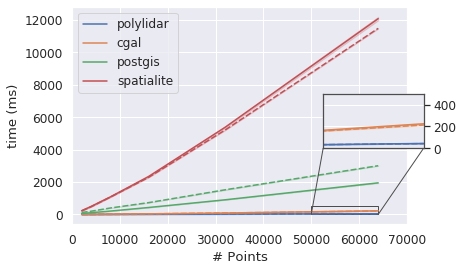

In [5]:
plt.close(plt.gcf())
df_mi = df_all_section[df_all_section['shape'].isin(['miglove'])]
df_mi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['miglove'])]
plot_time(df_mi, df_mi_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_mi.pdf', bbox_inches='tight')

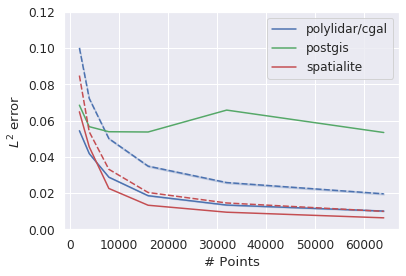

In [6]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_mi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_mi.pdf', bbox_inches='tight')
# g.set(yscale="log")

In [7]:
df_mi_means = df_mi.groupby(['points', 'alg'])[['time', 'l2_norm']].mean()
df_mi_means = df_mi_means.reset_index()
df_p = df_mi_means.pivot(index='alg', columns='points', values=['l2_norm']).round(3) * 100
df_p.reindex(["polylidar", "cgal", "postgis", 'spatialite'])

l2_norm                              
points       2000  4000  8000  16000 32000 64000
alg                                             
polylidar      7.8   5.7   4.0   2.7   2.0   1.5
cgal           7.7   5.7   3.9   2.6   1.9   1.5
postgis       15.2  14.1  13.0  13.9  14.4  13.9
spatialite     7.5   5.0   2.8   1.7   1.2   0.8

# CA

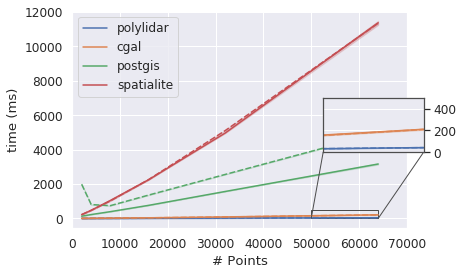

In [8]:
plt.close(plt.gcf())
df_ca = df_all_section[df_all_section['shape'].isin(['ca'])]
df_ca_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['ca'])]
plot_time(df_ca, df_ca_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_ca.pdf', bbox_inches='tight')

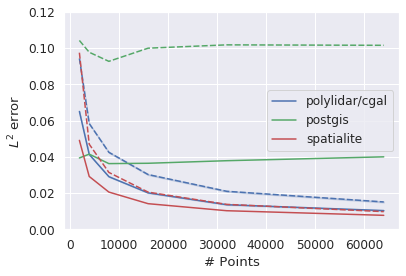

In [9]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_ca.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_ca.pdf', bbox_inches='tight')
# g.set(yscale="log")

# HI

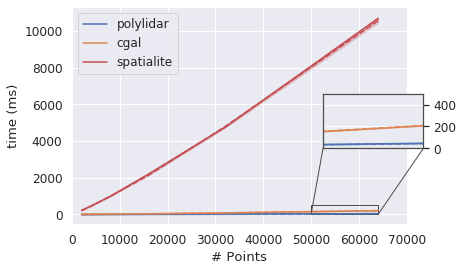

In [10]:
plt.close(plt.gcf())
df_hi = df_all_poly_cgal_spatialite[df_all_poly_cgal_spatialite['shape'].isin(['hi'])]
df_hi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['hi'])]
plot_time(df_hi, df_hi)

plt.savefig('assets/pics/compare_algs_time_inset_hi.pdf', bbox_inches='tight')

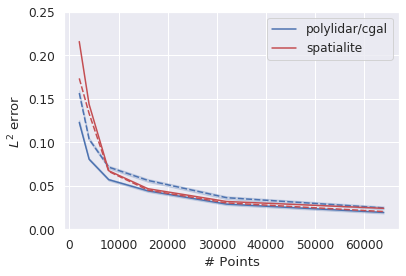

In [11]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_hi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal, y_lim=[0, 0.250])

plt.savefig('assets/pics/compare_algs_accuracy_hi.pdf', bbox_inches='tight')

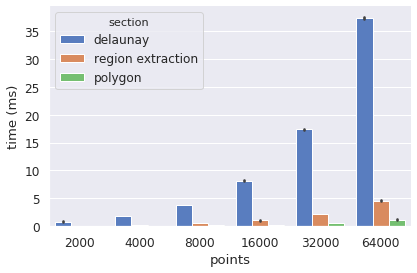

In [12]:
fig = plt.Figure((5,5))
df_pl_sec = df_pl_sec.replace('mesh', 'region extraction')
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted",
                hue_order=["delaunay", "region extraction", "polygon"],  height=4, aspect=1.5, legend_out=False)

g.set_ylabels("time (ms)")
g.savefig('assets/pics/polylidar_decomposed.pdf')
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")

In [13]:
df_pl_sec_miglove = df_pl_sec[df_pl_sec['shape'] == 'miglove']

df_new = df_pl_sec_miglove.groupby([df_pl_sec_miglove['section'], df_pl_sec_miglove['points']]).mean()
df_new = df_new.reset_index()
df_delaunay = df_new[df_new['section'] == 'delaunay']
df_mesh = df_new[df_new['section'] == 'mesh']
df_polygon = df_new[df_new['section'] == 'polygon']

delaunay_diff = df_delaunay['time'].pct_change().reset_index()
mesh_diff = df_mesh['time'].pct_change().reset_index()
polygon_diff = df_polygon['time'].pct_change().reset_index()

values = []
names = ['delaunay_PctChange', 'mesh_PctChange', 'polygon_PctChange']
values.append(delaunay_diff.values[1:,1])
values.append(mesh_diff.values[1:, 1])
values.append(polygon_diff.values[1:, 1])

pd.DataFrame.from_items(zip(names, values))



/home/jeremy/miniconda3/envs/concave/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


# Alphabet Comparison

In [14]:
df = pd.read_csv('./test_fixtures/results/alphabet_results.csv')
df.head(n=10)

,alg,shape,points,l2_norm,time,holes,section,convexity
0,polylidar,A,2000,0.135555,1.147000,True,all,0.464088
1,cgal,A,2000,0.133860,5.375000,True,all,0.464088
2,spatialite,A,2000,0.133987,223.908186,True,all,0.464088
3,postgis,A,2000,0.254662,4270.989895,True,all,0.464088
4,polylidar,B,2000,0.137405,1.079000,True,all,0.457297
5,cgal,B,2000,0.135875,5.829000,True,all,0.457297
6,spatialite,B,2000,0.097786,237.270594,True,all,0.457297
7,postgis,B,2000,0.372216,4696.243525,True,all,0.457297
8,polylidar,C,2000,0.114009,1.042000,False,all,0.315637
9,cgal,C,2000,0.112247,5.990000,False,all,0.315637


In [15]:
# CGAL accuracy is the SAME as Polylidar (same alpha, same shape). These small numerical differences are inadvertantly introduced
# when I convert the unsorted edges of CGAL into a polygon. I use a very small buffer to the edges causing them to be slightly
# bigger than they the true shape returned. 
# I am overwriting the l2 norm of CGAL with Polylidar because that is the TRUE accuracy (of the unmodified edges returned from CGAL)

cgal_indices = df.index[df['alg'] == 'cgal']
df.loc[cgal_indices, "l2_norm"] = df[df['alg'] == 'polylidar']['l2_norm'].values
df.head(n=10)

,alg,shape,points,l2_norm,time,holes,section,convexity
0,polylidar,A,2000,0.135555,1.147000,True,all,0.464088
1,cgal,A,2000,0.135555,5.375000,True,all,0.464088
2,spatialite,A,2000,0.133987,223.908186,True,all,0.464088
3,postgis,A,2000,0.254662,4270.989895,True,all,0.464088
4,polylidar,B,2000,0.137405,1.079000,True,all,0.457297
5,cgal,B,2000,0.137405,5.829000,True,all,0.457297
6,spatialite,B,2000,0.097786,237.270594,True,all,0.457297
7,postgis,B,2000,0.372216,4696.243525,True,all,0.457297
8,polylidar,C,2000,0.114009,1.042000,False,all,0.315637
9,cgal,C,2000,0.114009,5.990000,False,all,0.315637


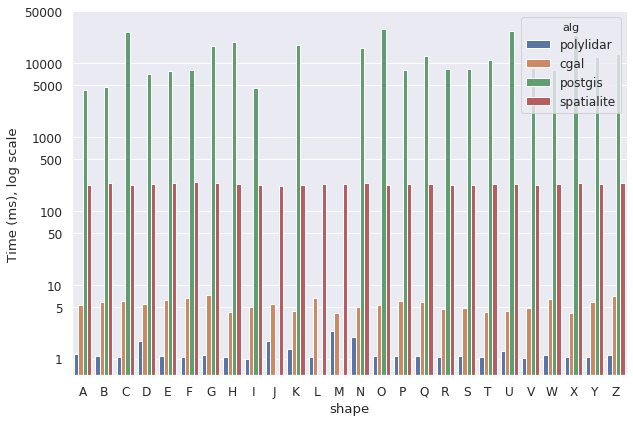

In [16]:
# Draw a nested barplot to show survival for class and sex
ticks = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
labels = [i for i in ticks]
order = ['polylidar', 'cgal', 'postgis', 'spatialite']
# df_ = df[df['alg'].isin(['polylidar', 'cgal', 'spatialite'])]
g = sns.catplot(x="shape", y="time", hue="alg", data=df,
                height=6, kind="bar", aspect=1.5, hue_order=order, legend_out=False)
# g.despine(left=True)
g.set(yscale = 'log')
g.set(yticks = ticks, yticklabels = labels)
g.set_ylabels("Time (ms), log scale")
g.savefig('assets/pics/alphabet_time.pdf')

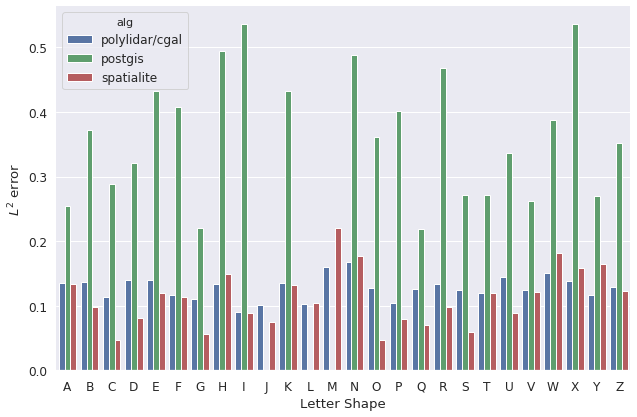

In [17]:
# Polylidar and cgal have the same l2 error
df_ =  df.replace('polylidar', 'polylidar/cgal')
df_ =  df_[df_['alg'].isin(['polylidar/cgal', 'postgis', 'spatialite'])]

order = ['polylidar/cgal', 'postgis', 'spatialite']
palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}
# df_ = df[df['alg'].isin(['polylidar', 'cgal', 'spatialite'])]
g = sns.catplot(x="shape", y="l2_norm", hue="alg", data=df_,
                height=6, kind="bar", palette=palette, aspect=1.5, hue_order=order, legend_out=False)
g.despine(left=True)
# g.set(yscale = 'log')
# g.set(yticks = ticks, yticklabels = labels)
g.set_ylabels(r'$L^2$ error')
g.set_xlabels("Letter Shape")
g.savefig('assets/pics/alphabet_accuracy.pdf')

## Alphabet Table

In [18]:
df_result = df.groupby(['shape', 'alg']).agg(
    {'l2_norm':['mean','std', 'max'],'time':['mean', 'std', 'max']})
df_result= df_result.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)"})
# df_result = df_result.reindex(['very hi','hi', 'mid', 'low'], level='$C$')
# print(df_result.to_latex(escape=False, float_format="%.1f"))
df_result

$L^2\%$                   time (ms)                  
                      mean std       max          mean std           max
shape alg                                                               
A     cgal        0.135555 NaN  0.135555      5.375000 NaN      5.375000
      polylidar   0.135555 NaN  0.135555      1.147000 NaN      1.147000
      postgis     0.254662 NaN  0.254662   4270.989895 NaN   4270.989895
      spatialite  0.133987 NaN  0.133987    223.908186 NaN    223.908186
B     cgal        0.137405 NaN  0.137405      5.829000 NaN      5.829000
...                    ...  ..       ...           ...  ..           ...
Y     spatialite  0.164383 NaN  0.164383    228.364706 NaN    228.364706
Z     cgal        0.128382 NaN  0.128382      6.949000 NaN      6.949000
      polylidar   0.128382 NaN  0.128382      1.104000 NaN      1.104000
      postgis     0.351704 NaN  0.351704  13066.244125 NaN  13066.244125
      spatialite  0.122160 NaN  0.122160    240.252256 NaN    240.252256

[104 rows x 6 columns]

In [19]:
df_result = df.pivot(index='shape', columns='alg', values=['l2_norm', 'time'])
column_order = ['polylidar', 'cgal', 'postgis', 'spatialite']
df_result = df_result.reindex(column_order, axis=1, level=1)
# df_result = df_result.drop('cgal', axis=1, level=1)
df_result
# print(df_result.to_latex(escape=False, float_format="%.2f"))

l2_norm                                     time                       \
alg   polylidar      cgal   postgis spatialite polylidar   cgal       postgis   
shape                                                                           
A      0.135555  0.135555  0.254662   0.133987     1.147  5.375   4270.989895   
B      0.137405  0.137405  0.372216   0.097786     1.079  5.829   4696.243525   
C      0.114009  0.114009  0.288218   0.047138     1.042  5.990  25869.033337   
D      0.140256  0.140256  0.321616   0.080481     1.733  5.450   7066.979170   
E      0.140251  0.140251  0.433199   0.119630     1.089  6.270   7785.628796   
F      0.116335  0.116335  0.408250   0.112803     1.042  6.577   7920.193195   
G      0.109655  0.109655  0.219907   0.056624     1.128  7.181  17073.376656   
H      0.133344  0.133344  0.494306   0.149491     1.050  4.208  19406.121731   
I      0.090254  0.090254  0.536804   0.088378     0.991  5.036   4594.065189   
J      0.100470  0.100470       NaN   0.075413     1.701  5.467           NaN   
K      0.135261  0.135261  0.431734   0.132344     1.346  4.453  17345.828295   
L      0.102380  0.102380       NaN   0.104100     1.038  6.570           NaN   
M      0.159733  0.159733       NaN   0.221086     2.355  4.111           NaN   
N      0.168214  0.168214  0.487505   0.177283     1.979  4.942  15984.241009   
O      0.127089  0.127089  0.360885   0.047098     1.070  5.222  28451.025009   
P      0.104338  0.104338  0.401345   0.079592     1.078  6.048   8056.225061   
Q      0.125628  0.125628  0.218797   0.070444     1.073  5.757  12234.314442   
R      0.133319  0.133319  0.468685   0.098078     1.062  4.733   8235.842705   
S      0.123636  0.123636  0.271116   0.058653     1.068  4.779   8230.390072   
T      0.120435  0.120435  0.270832   0.119206     1.035  4.262  10938.446283   
U      0.144231  0.144231  0.336293   0.088868     1.266  4.412  27201.931000   
V      0.124820  0.124820  0.262378   0.120819     1.020  4.790   8661.818266   
W      0.150889  0.150889  0.387041   0.182041     1.120  6.367   8038.235188   
X      0.138296  0.138296  0.536506   0.159025     1.040  4.161  24091.649055   
Y      0.116016  0.116016  0.269829   0.164383     1.040  5.815  11891.839504   
Z      0.128382  0.128382  0.351704   0.122160     1.104  6.949  13066.244125   

                   
alg    spatialite  
shape              
A      223.908186  
B      237.270594  
C      224.123478  
D      228.280067  
E      238.639116  
F      242.914677  
G      237.639189  
H      232.045650  
I      225.733042  
J      215.098619  
K      225.561619  
L      229.115009  
M      227.564096  
N      236.182690  
O      226.393700  
P      233.745337  
Q      230.635881  
R      225.625515  
S      224.292278  
T      232.495785  
U      228.501320  
V      224.705696  
W      232.060432  
X      234.246731  
Y      228.364706  
Z      240.252256

In [20]:
df1 = df_result["l2_norm"].drop('cgal', axis=1) * 100
df1 =df1.rename(columns=dict(polylidar='polylidar/cgal'))
df2 = df_result["time"] 

df_joined = pd.concat([df1,df2],axis=1,keys=['l2_norm','time'])
df_joined = df_joined.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)", 'polylidar': 'PL', 'cgal':'CG',
                                        'postgis': 'PG', 'spatialite': 'SL', 'polylidar/cgal': 'PL/CG'})
print(df_joined.to_latex(escape=False, float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{$L^2\%$} & \multicolumn{4}{l}{time (ms)} \\
alg &   PL/CG &   PG &   SL &        PL &  CG &      PG &    SL \\
shape &         &      &      &           &     &         &       \\
\midrule
A     &    13.6 & 25.5 & 13.4 &       1.1 & 5.4 &  4271.0 & 223.9 \\
B     &    13.7 & 37.2 &  9.8 &       1.1 & 5.8 &  4696.2 & 237.3 \\
C     &    11.4 & 28.8 &  4.7 &       1.0 & 6.0 & 25869.0 & 224.1 \\
D     &    14.0 & 32.2 &  8.0 &       1.7 & 5.5 &  7067.0 & 228.3 \\
E     &    14.0 & 43.3 & 12.0 &       1.1 & 6.3 &  7785.6 & 238.6 \\
F     &    11.6 & 40.8 & 11.3 &       1.0 & 6.6 &  7920.2 & 242.9 \\
G     &    11.0 & 22.0 &  5.7 &       1.1 & 7.2 & 17073.4 & 237.6 \\
H     &    13.3 & 49.4 & 14.9 &       1.1 & 4.2 & 19406.1 & 232.0 \\
I     &     9.0 & 53.7 &  8.8 &       1.0 & 5.0 &  4594.1 & 225.7 \\
J     &    10.0 &  NaN &  7.5 &       1.7 & 5.5 &     NaN & 215.1 \\
K     &    13.5 & 43.2 & 13.2 &       1.3 & 4.5 & 17345.8 & 22

## Alphabet Aggregate

In [21]:
df[['l2_norm%']] = df[['l2_norm']] * 100
df_all = df.groupby(['alg']).agg(
    {'l2_norm%':['mean','std', 'max'],'time':['mean', 'std', 'max']})
column_order = ['polylidar', 'cgal', 'postgis', 'spatialite']

df_all = df_all.reindex(column_order, axis=0)
df_all = df_all.rename(columns={"l2_norm%": "$L^2$ error \%", "time": "time (ms)"})
df_all

$L^2$ error \%                          time (ms)               \
                     mean       std        max          mean          std   
alg                                                                         
polylidar       12.770007  1.830245  16.821447      1.219077     0.339429   
cgal            12.770007  1.830245  16.821447      5.413615     0.908497   
postgis         36.451419  9.883533  53.680355  13091.767892  7500.582421   
spatialite      11.180433  4.454599  22.108550    230.207526     6.263953   

                          
                     max  
alg                       
polylidar       2.355000  
cgal            7.181000  
postgis     28451.025009  
spatialite    242.914677

In [22]:
print(df_all.to_latex(escape=False, float_format="%.1f"))

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{$L^2$ error \%} & \multicolumn{3}{l}{time (ms)} \\
{} &           mean & std &  max &      mean &    std &     max \\
alg        &                &     &      &           &        &         \\
\midrule
polylidar  &           12.8 & 1.8 & 16.8 &       1.2 &    0.3 &     2.4 \\
cgal       &           12.8 & 1.8 & 16.8 &       5.4 &    0.9 &     7.2 \\
postgis    &           36.5 & 9.9 & 53.7 &   13091.8 & 7500.6 & 28451.0 \\
spatialite &           11.2 & 4.5 & 22.1 &     230.2 &    6.3 &   242.9 \\
\bottomrule
\end{tabular}



In [23]:
df['convexity'].mean()

0.38079346212223125